# Map Tutorial in R

<br>

 This tutorial is designed to get you started with creating spatial maps in R with vector and raster data.
  
 The tutorial’s objectives include learning how to: 
 * Understand the advantages of using tmap vs ggplot in R for map creation
 * Add specific mapping features such as a compass and scale to maps
 * Learn how to position legends on maps 
 * Review important aesthetic features of a map 
 * Plot multiple plots onto a map  


<br>

## Analysis Preparation

### Install and load the relevant packages

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use ```install.packages(c('sf', 'dplyr', 'tmap', 'leaflet', 'ggplot2'))```. If you are running this tutorial locally, you may have to install tmap and leaflet.

In [1]:
library(sf)
library(raster)
library(dplyr)
library(tmap)  
library(leaflet) 
library(ggplot2)

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

Warning message:
"package 'sf' was built under R version 3.6.3"Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1
Warning message:
"package 'raster' was built under R version 3.6.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.6.2"Warning message:
"package 'tmap' was built under R version 3.6.3"Warning message:
"package 'leaflet' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"

<br>

tmaps is the primary package used throughout this tutorial. It is flexible map-making package whose syntax is readible and mirrors that of ggplot to create attractive maps. 

Unlike ggplot, tmaps can take on multiple forms of spatial objects with ease. To examine the functions of this package we will incorporate the vector and raster files used in tutorials 3 and 4. Once the map-making skills have been developed, they can be used in conjunction with the spatial analysis tools developed in the prior tutorials to create maps much more detailed and meaningful than those created in this tutorial.

<br>

### Loading Data

We'll start by again checking to see if we need to download any data

In [2]:
download_data()

<br>

### Download the data:

In [3]:
countries <- read_sf("../data/africa/countries.shp")
zambia <- subset(countries, countries$NAME == 'Zambia')
land_cover <- raster('../data/africa/land_cover.tif')

# we can then crop the land_use raster to Zambia's extent as in tutorial 4
land_cover_zambia <- crop(land_cover, zambia)
land_cover_zambia <- mask(land_cover_zambia, zambia)

# determine the CRS 
st_crs(countries)

Coordinate Reference System:
  User input: WGS 84 
  wkt:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]

<br>

It is necessary to project the files onto the same CRSs. 

When running the line 'st_crs(countries)', it can be seen that the CRS connected to the data is WGS 84. This means that its default is a geographical reference system, giving it the units of degrees. 

A crucial component of a map is its scale bar, this contextualises the map as we will see later in the tutorial. It is therefore necessary to project the spatial objects to convert the units into meters such that the units are meaningful. In this context, UTM 35s is an ideal projection for Southern Africa. 

In [4]:
# define the relevant CRS
crs <- '+proj=utm +zone=35 +south +datum=WGS84 +units=m +no_defs' 

# convert the sf objects 
countries_utm35s <- st_transform(countries, crs=crs)
zambia_utm35s <- st_transform(zambia, crs=crs)

# convert the raster object 
land_cover_zambia_utm35s <- projectRaster(land_cover_zambia, crs=crs)


<br>

For a visual comparison of the same objects being present by ggplot2 and tmaps use the code below. 

ggplot easily reads sf objects by using geom_sf(). Characteristics can then be defined in the same line. And subsequent layers added. 

tmaps defines the layer through the tm_shape() function. Characteristics are then added sequentionally through various tm_* functions. In application, * can take the form of 'fill', 'borders' and 'polygons' to name a few. 

New shape layers can be added similarly to ggplot, where the most recent line is presented as the top layer. All subsequent tm_* commands correspond to the most recent tm_shape() layer. 

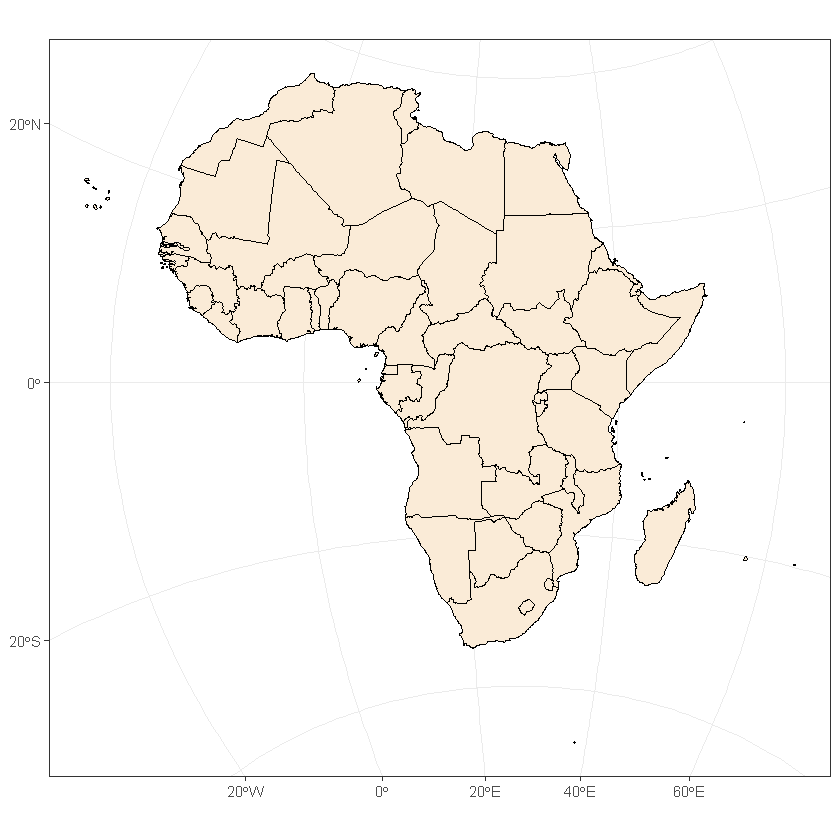

In [12]:
# continent & country outlines can be represented through ggplot as:
ggplot() +
  geom_sf(data = countries_utm35s, color = 'black', fill = 'antiquewhite') +
  theme_bw()


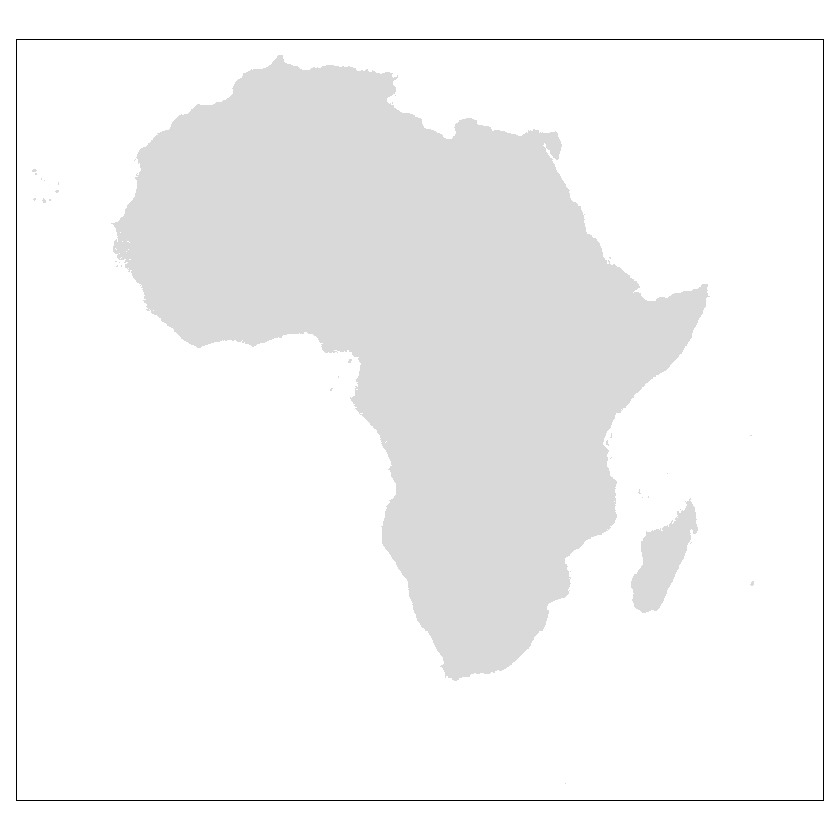

In [14]:
# equivelant representation through tmaps showing layer development add fill with default colouring
tm_shape(countries_utm35s) +
  tm_fill() 

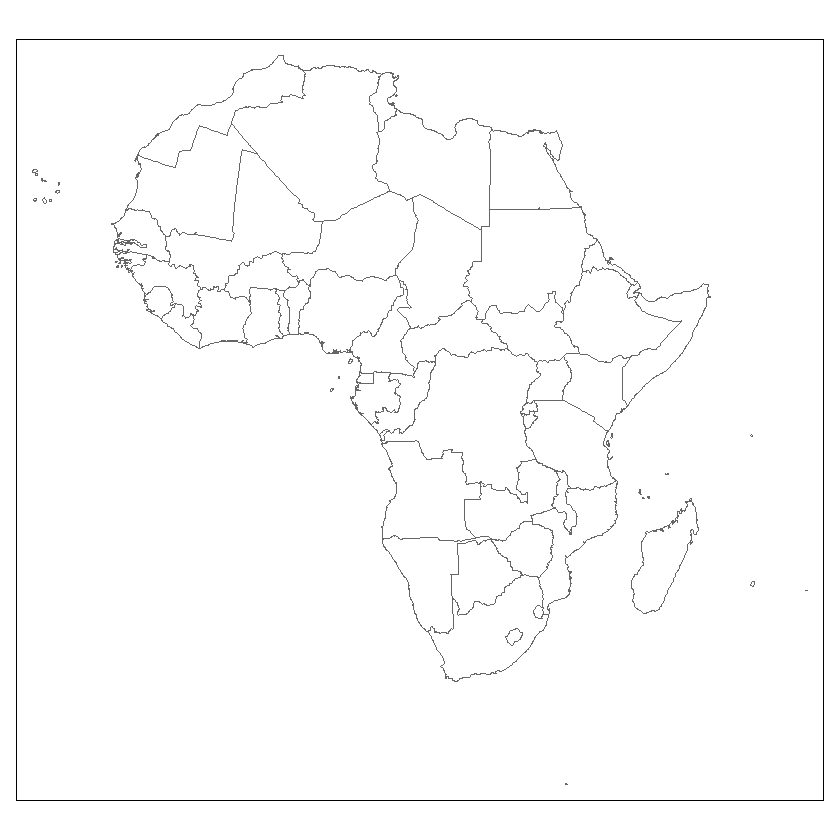

In [15]:
# add border layer only to the map
tm_shape(countries_utm35s) +
  tm_borders() 

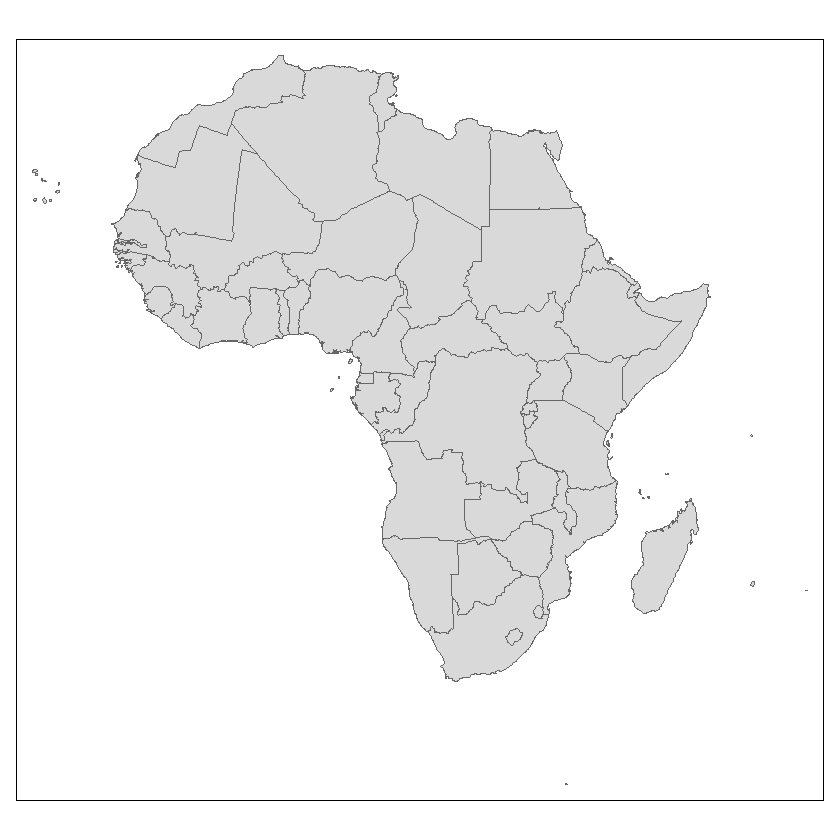

In [16]:
# combine these two for a more complete representation
tm_shape(countries_utm35s) +
  tm_fill() +
  tm_borders() 

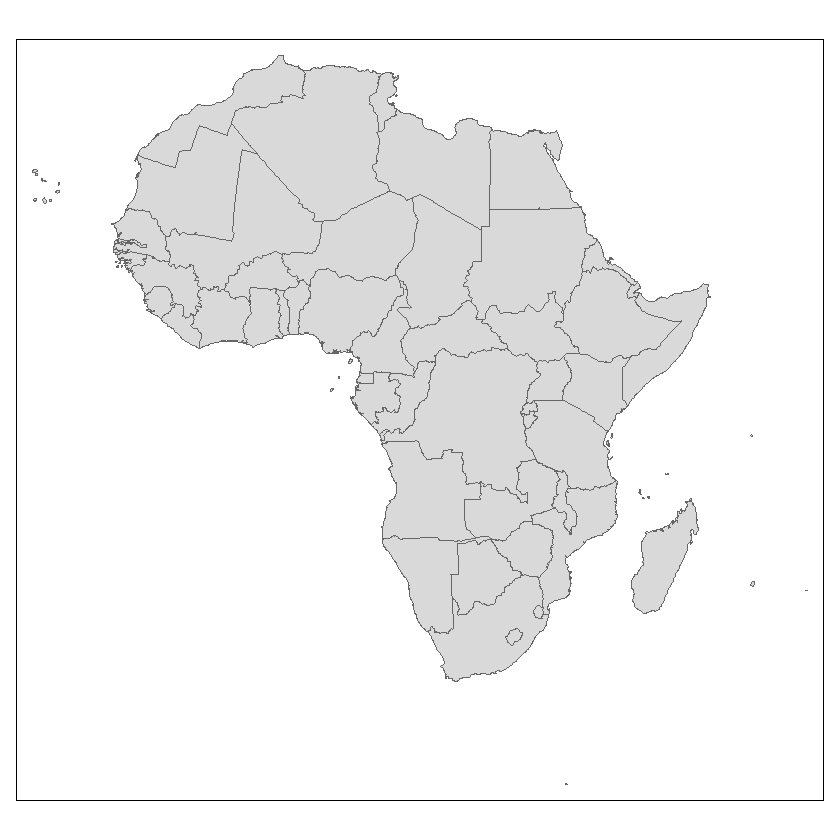

In [18]:
# this can also be achieved through tm_polygons()  
tm_shape(countries_utm35s) + 
  tm_polygons()

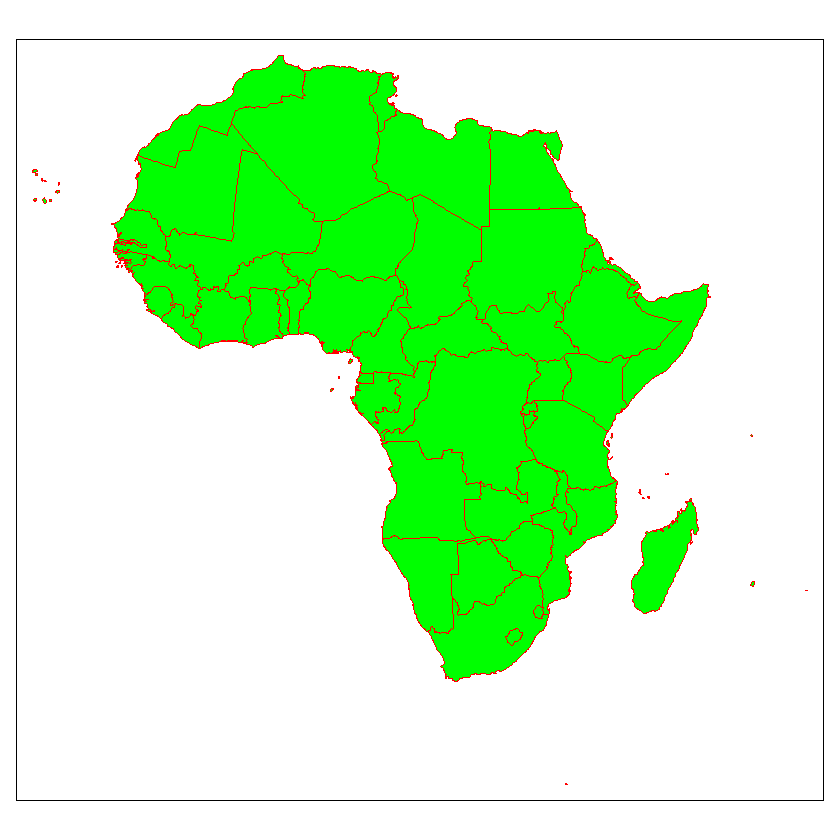

In [19]:
# you can add detail to each layer  
tm_shape(countries_utm35s) +
  tm_fill(col = 'green') +
  tm_borders(col = 'red')

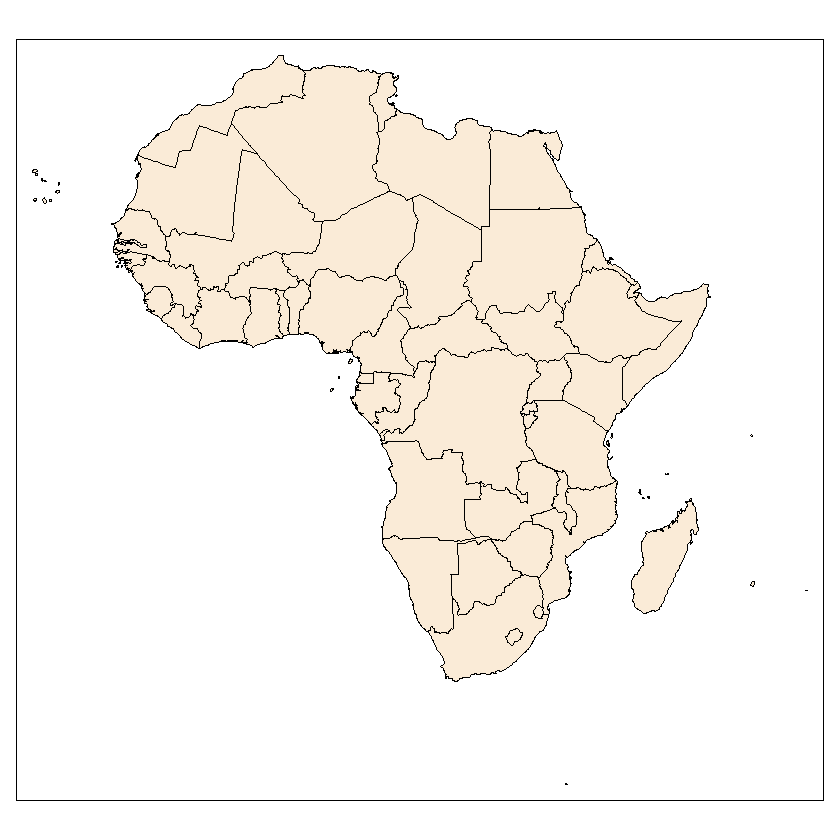

In [20]:
# selecting a complimentary combination of colours for the map can benefit its readibility significantly i.e., not using vivid greens and reds
tm_shape(countries_utm35s) +
  tm_fill(col = 'antiquewhite') +
  tm_borders(col = 'black')


<br>

The addition of new layers can be shown by plotting the zambia layer on top of the countries layer. 

New shapes can be added sequentially with a new tm_shape() component. The package applies commands hierarchally where all prompts after a new tm_shape()layer apply to the the most recent shape layer

First we can highlight Zambia with ggplot

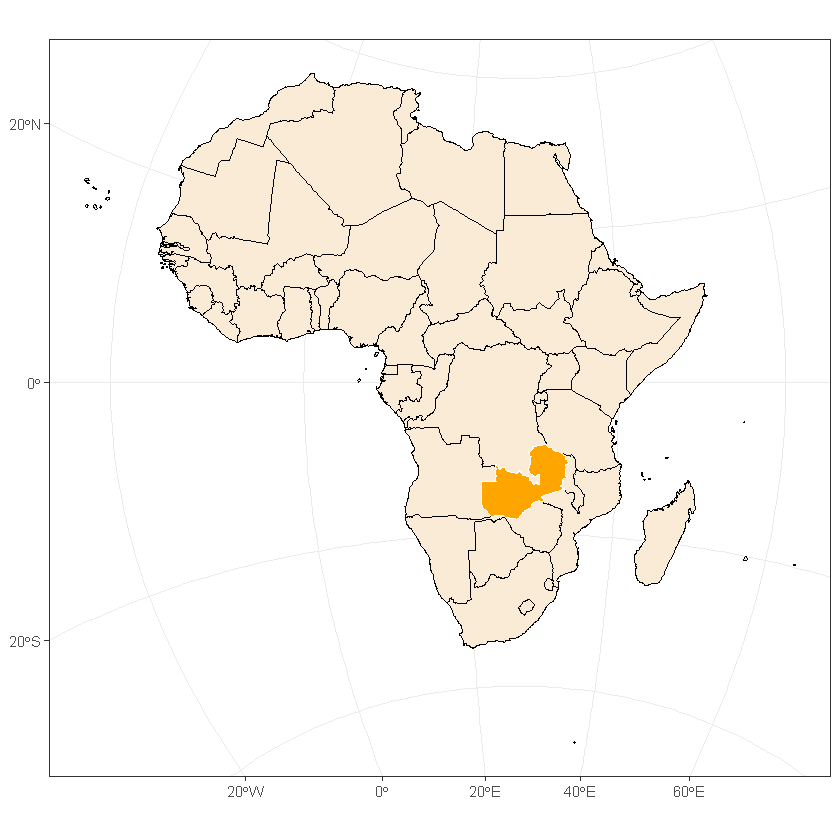

In [9]:
ggplot() +
  geom_sf(data = countries_utm35s, color = 'black', fill = 'antiquewhite') +
  geom_sf(data = zambia_utm35s, color = 'white', fill = 'orange') +
  theme_bw()



<br>
Plotted with tmaps

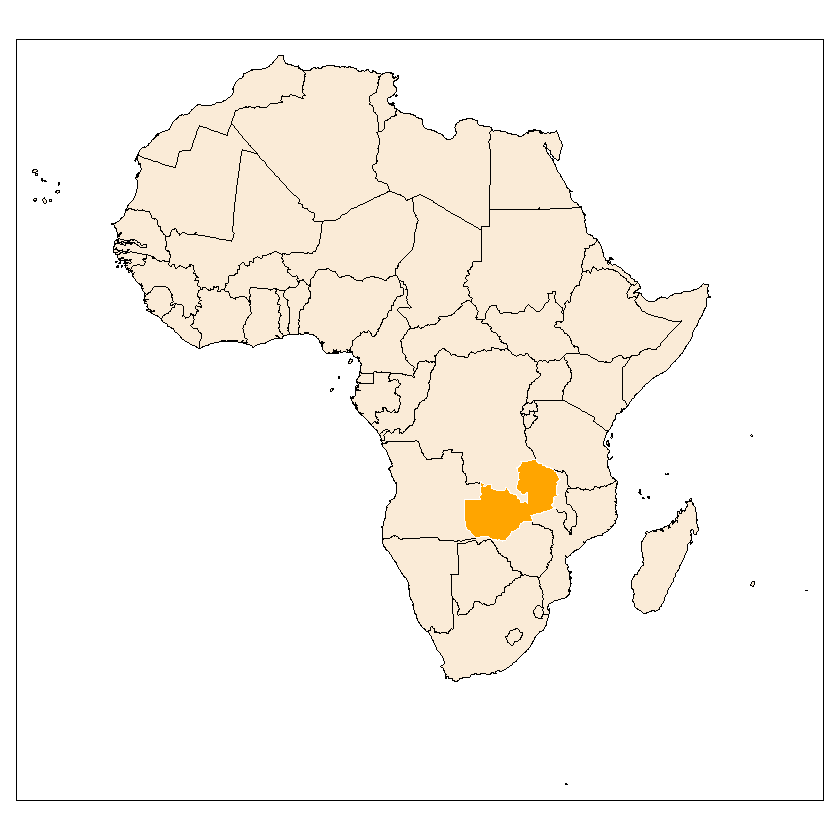

In [21]:
# represented through tmaps
tm_shape(countries_utm35s) +
  tm_fill(col = 'antiquewhite') +
  tm_borders(col = 'black') +
  tm_shape(zambia_utm35s) +
  tm_fill(col = 'orange') +
  tm_borders(col = 'white')

<br>

R can have a hard time processing large raster files. Because of this it is necessary that we focus on small areas to help run this tutorial quickly. For this, we can reduce the size of the countries file to match the extent of the zambia file. 

In [5]:
# determining the extent of the zambia file
ext_zamb <- extent(zambia_utm35s)
xmin <- ext_zamb[1] - 100000
xmax <- ext_zamb[2] + 100000
ymin <- ext_zamb[3] - 100000
ymax <- ext_zamb[4] + 100000 # we change the extent to buffer around the country

reduced_countries_utm35s <- st_crop(countries_utm35s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)


Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"

<br>

Again, this can be represented through ggplot and a layered tmaps. 

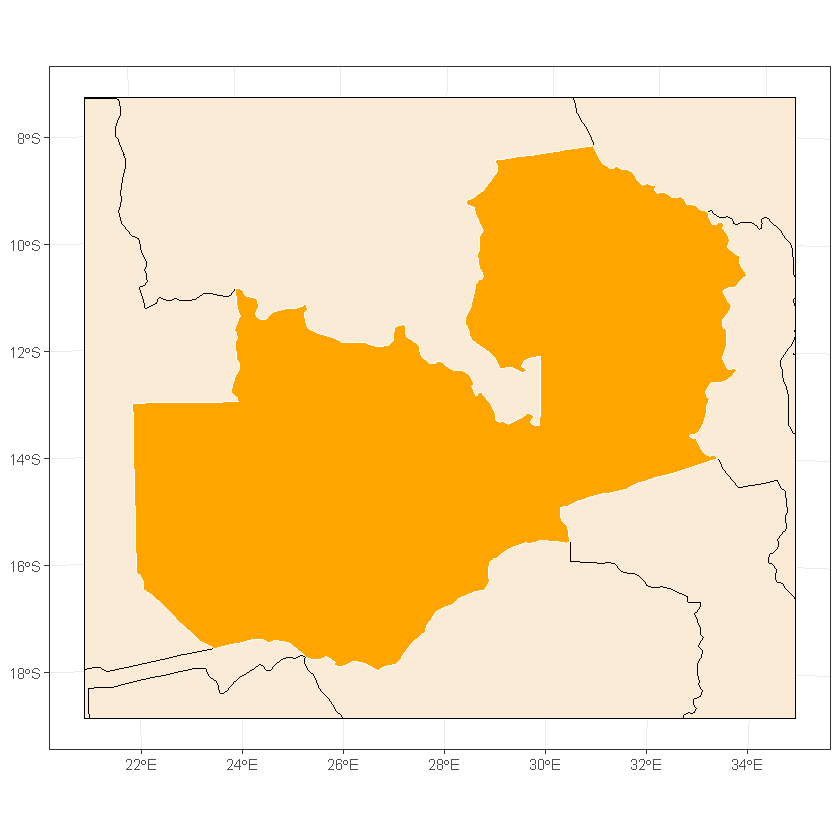

In [23]:
# represented through ggplot
ggplot() +
  geom_sf(data = reduced_countries_utm35s, color = 'black', fill = 'antiquewhite') +
  geom_sf(data = zambia_utm35s, color = 'white', fill = 'orange') +
  theme_bw()



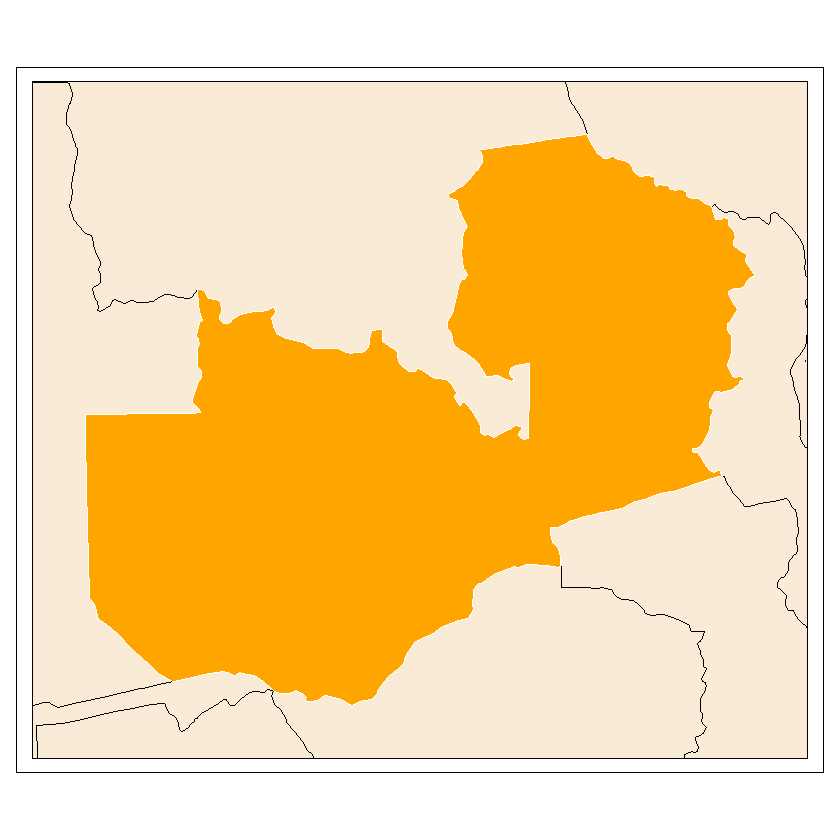

In [24]:
# represented through tmaps
tm_shape(reduced_countries_utm35s) +
  tm_fill(col = 'antiquewhite') +
  tm_borders(col = 'black') +
  tm_shape(zambia_utm35s) +
  tm_fill(col = 'orange') +
  tm_borders(col = 'white')

<br>

Further information can be added other than colour. Some common uses are:

1. Transparancy (alpha = *)
2. Linewidth (lwd = *)
3. Linetype (lty = *)

You can also save the maps as an object to be added to later in the process. This allows you to keep multiple versions of the map with new layer additions. This is efficient as it means you can change the odd line of code simply rather than route through many lines of layers. The objects saved as class "tmap" and can be plotted using the print() function. 

[1] "tmap"

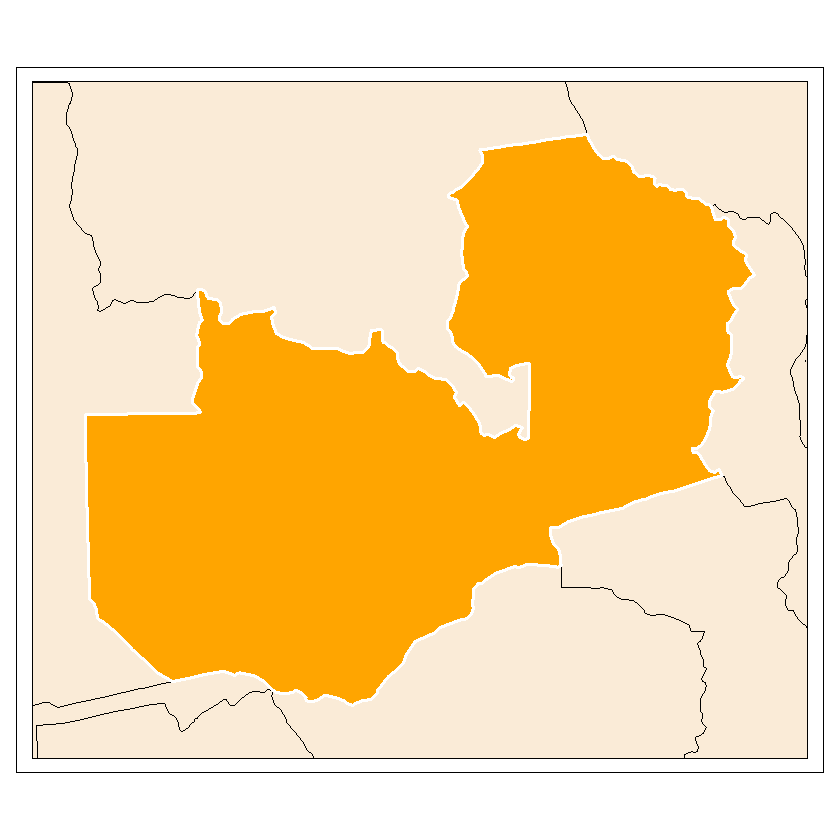

In [6]:
map_zambia_one <- tm_shape(reduced_countries_utm35s) +
  tm_fill(col = 'antiquewhite') +
  tm_borders(col = 'black') +
  tm_shape(zambia_utm35s) +
  tm_fill(col = 'orange') +
  tm_borders(col = 'white', lwd = 3)
class(map_zambia_one)
print(map_zambia_one)

<br>

The difference between the ggplot representations and tmaps representations comes when adding a raster layer. This can be done using tm_raster as in the following lines of code. 

First the tm_shape() must be defined with the raster object within it, then the tm_raster() function must be defined. It is the raster function that controls the appearance of the layer. General parameters can be controlled using the tm_layout() function:

In [8]:
map_zambia_two <- map_zambia_one + 
  tm_shape(land_cover_zambia_utm35s) + 
  tm_raster()
class(map_zambia_two)


[1] "tmap"

In [9]:
print(map_zambia_two)

<br>

There are couple of things wrong with this plot. 

First of all, the legend interferes with features on the map making it unclear. You can move the legend either by using the 'legend.position = *' element by specifying its location with commands like 'left', 'right', 'top' and 'bottom'. Alternatively, you can use 'legend.outside = TRUE' to take the legend outside of the map. 

Secondly, the legend title is defaulted as the column title, this can make it ugly. Within the tm_raster() function the legend title can be defined by using 'title = *'.

Finally, the color doesn't fit the information. The default colour ramp of yellow-red is suitable for attributes such as solar irradiance. However, a green colour ramp is much better suited for land coverage. 

In [ ]:
# editting the legend
map_zambia_two <- map_zambia_one + 
  tm_shape(land_cover_zambia_utm35s) + 
  tm_raster() +
  tm_layout(legend.position = c('right', 'bottom'))
print(map_zambia_two)

In [ ]:
map_zambia_two <- map_zambia_one + 
  tm_shape(land_cover_zambia_utm35s) + 
  tm_raster() +
  tm_layout(legend.outside = TRUE)
print(map_zambia_two)

In [ ]:
# Editing the legend title & changing the colour theme
legend <- paste('Land Cover')
map_zambia_two <- map_zambia_one + 
  tm_shape(land_cover_zambia_utm35s) + 
  tm_raster(title = legend, palette = 'Greens') +
  tm_layout(legend.outside = TRUE)
print(map_zambia_two)

<br>


You can plot maps side-by-side by using the tmap_arrange() function. This is a useful way to assess progress or to compare feature choices to determine which option works best. 

In [ ]:
tmap_arrange(map_zambia_one, map_zambia_two)

<br>

Two vital map elements are a compass, to orientate the map to the viewer, and the scale bar, to contextualise the distance/separation. 

You can edit the characteristics of these elements. Some examples are shown below. 

The arrow type, and position can be edited easily. The compasses position depends on the map's composition and is best to avoid cluttered areas.  

Scale bars automatically adjust their size based on your specified distance. The units of the inputs are meters, as per the projected CRS.

In [ ]:
# compass elements
# position
map_zambia_two + 
  tm_compass(position = c('left', 'top'))
map_zambia_two + 
  tm_compass(position = c('left', 'bottom'))
# compass type
map_zambia_two + 
  tm_compass(type = '4star', position = c('left', 'top'))
map_zambia_two + 
  tm_compass(type = '8star', position = c('left', 'top'))
    
# scale bar size 
map_zambia_two + 
  tm_scale_bar(breaks = c(0, 100, 200))
map_zambia_two + 
  tm_scale_bar(breaks = c(0, 250, 500))

<br>

These elements can be edited further. The color, size and alpha of the elements are shown below:

In [ ]:
map_zambia_two + 
  tm_compass(type = '8star', position = c('left', 'top'), bg.color = 'red')
map_zambia_two + 
  tm_compass(type = '8star', position = c('left', 'top'), bg.color = 'red', size = 10)
map_zambia_two + 
  tm_compass(type = '8star', position = c('left', 'top'), bg.color = 'red', size = 10, bg.alpha = 0.5)

map_zambia_two + 
  tm_scale_bar(breaks = c(0, 200, 400), bg.color = 'blue', bg.alpha = 0.25)


<br>


Map elements can have titles added can be added to the map in the tm_layout() function. The legend title can be changed using the 'title = *' elements. Title characteristics cam ne modified using 'title.* =' where the *, in this case, can be replaced with color, size and position among others. 

The map's main title can be defined using 'main.title = *'. Similarly to before, the title's characteristics are defined using 'main.title.* =', where * can also be replaced with color, size and position among others.

They can also be used in conjunction for extra detaul. 

In [1]:
# types of titles 
map_zambia_two +
  tm_layout(title = 'Legend')
    
map_zambia_two +
  tm_layout(main.title = 'Zambia Test Map')


map_zambia_two +
  tm_layout(main.title = 'Zambia Test Map', 
            title = 'Legend:')
    
# title characteristics 
map_zambia_two +
  tm_layout(main.title = 'Zambia Test Map', main.title.size = 2, main.title.position = c('right', 'top'), 
            main.title.color = 'red', main.title.fontface = 'bold')


SyntaxError: invalid syntax (<ipython-input-1-7e0fa539e59b>, line 1)

<br>

The map's border can be removed using the following code. This can help improve the map's neatness. 

In [ ]:
map_zambia_two +
  tm_layout(frame = FALSE)

<br>

All of these elements together can be used to produce a map of reasonable complexity. 

In [ ]:
map_zambia_three <- map_zambia_two + 
  tm_compass(type = '8star', position = c('left', 'top'), bg.color = 'black', bg.alpha = 0.5, size = 2) + 
  tm_scale_bar(breaks = c(0, 200, 400), bg.color = 'black', bg.alpha = 0.5) +
  tm_layout(main.title = 'Zambia Test Map', main.title.size = 2, main.title.position = c('left', 'top'), main.title.fontface = 'bold', 
            title = 'Legend:', title.size = 1.5, 
            frame = FALSE)
print(map_zambia_three)

<br>

Further shape layers can be added through more tm_shape() layers. Following the mechanism in tutorial 3, the cities inside Zambia can be identified. 

In [ ]:
cities <- read_sf("data/africa/cities.shp")
cities_utm35s <- st_transform(cities, crs=crs)
cities_utm35s_intersect <- st_intersects(cities_utm35s, zambia_utm35s, sparse=FALSE)

intersected_cities_idxs <- which(cities_utm35s_intersect)

idx <- intersected_cities_idxs[1]
cities_utm35s[idx, 'COUNTRY']

zambia_cities_utm35s <- cities_utm35s[intersected_cities_idxs, ]

<br>

These can be represented in an analogous way to ggplot. 

In [ ]:
map_zambia_two + 
  tm_shape(zambia_cities_utm35s) +
  tm_symbols(col = 'black', size = 0.5, border.col = 'white', shape = 22)


<br>

This additional layer will be shown using the mechanisms stated previously. It is often useful to plot the shape layer to represent a characteristic of the layer.

Before being added to the map, we find the large cities within Zambia. In this case, large cities is defined as all cities that had a population of 50,000 or greater in 1990. 

This, however, makes the map untidy. In order to make the legend neater, the ES90POP column can be edited to show the population in thousdands or millions of people. It is an elemment of the map that significant figures must be suitable for the map's purpose. 

It is important that the legend titles, given by 'title.size = *', must readible. If the line is too long, automatically reducing the fontsize, the symbol '\n' can be used to create a new line. 

Both cases, thousands and millions, are shown below. 

In [ ]:
# subsetting the df to be only the 'big' cities 
# populations of 50,000+ in 1990
zambia_big_cities_utm35s <- subset(zambia_cities_utm35s, zambia_cities_utm35s$ES90POP > 50000)
map_zambia_two + 
  tm_shape(zambia_big_cities_utm35s) +
  tm_symbols(col = 'black', size = 'ES90POP', border.col = 'white', shape = 22, 
             title.size = '1990s Population')
# significant figures are important to keep the map neat

# population as thousands of people
zambia_big_cities_utm35s$ES90POP_neat_thous <- zambia_big_cities_utm35s$ES90POP/1000
map_zambia_two + 
  tm_shape(zambia_big_cities_utm35s) +
  tm_symbols(col = 'black', size = 'ES90POP_neat_thous', border.col = 'white', shape = 22, 
             title.size = '1990s Population (thousand)')

# the above map makes the legen title undreadable 
# '\n' creates a new line
map_zambia_two + 
  tm_shape(zambia_big_cities_utm35s) +
  tm_symbols(col = 'black', size = 'ES90POP_neat_thous', border.col = 'white', shape = 22, 
             title.size = '1990s Population \n(thousands)')

# population as millions of people
zambia_big_cities_utm35s$ES90POP_neat_mil <- zambia_big_cities_utm35s$ES90POP/1000000
map_zambia_two + 
  tm_shape(zambia_big_cities_utm35s) +
  tm_symbols(col = 'black', size = 'ES90POP_neat_mil', border.col = 'white', shape = 22, 
             title.size = '1990s Population \n(million)')


<br>

These can be combine to form an even more complete map.

In [ ]:
map_zambia_four <- map_zambia_three + 
  tm_shape(zambia_big_cities_utm35s) +
  tm_symbols(col = 'black', size = 'ES90POP_neat_mil', border.col = 'white', shape = 22, 
             title.size = '1990s Population \n(million)')
print(map_zambia_four)

<br>

The stages of the map-building process can be observed by plotting the four map iterations side-by-side. 

In [ ]:
tmap_arrange(map_zambia_one, map_zambia_two, map_zambia_three, map_zambia_four)

<br>
The map can be saved from R as a .svg, .pdf, .jpeg and ,tif files. These are completed as:

1. tmap_save(map_zambia_four, filename="map_zambia_four.svg", height=8.5, width=11, units="in", dpi=300) 
2. tmap_save(map_zambia_four, filename="map_zambia_four.pdf", height=8.5, width=11, units="in", dpi=300)
3. tmap_save(map_zambia_four, filename="map_zambia_four.jpeg", height=8.5, width=11, units="in", dpi=300)
4. tmap_save(map_zambia_four, filename="map_zambia_four.tiff", height=8.5, width=11, units="in", dpi=300)

In which circumstances would you use each file type?

it is useful to note that defining the size of the features gives them an absolute size regardless of the map's size. So, always bear this in mind before exporting the file as the elements can come out in different formats. 

For this example, please assess the difference between the following saves pdf's. 


In [ ]:
tmap_save(map_zambia_four, filename="map_zambia_four_small.pdf", height=4, width=5, units="in", dpi=300)
tmap_save(map_zambia_four, filename="map_zambia_four_big.pdf", height=8.5, width=11, units="in", dpi=300)


### Further Reading:

The following are links that motivated this tutorial:

1. https://cran.r-project.org/web/packages/cartography/vignettes/cartography.html
2. https://geocompr.robinlovelace.net/adv-map.html#introduction-5
3. https://www.youtube.com/watch?v=GMi1ThlGFMo&ab_channel=InfoWorld
4. http://www.wvview.org/spatial_analytics/Visualizing_Spatial_Data/_site/Visualize_Spatial_Data.html#write-to-file
